In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random

In [ ]:
def heightmap(height):

  if not os.path.exists(height):
    print(f"Warning: Segmentation map file not found: {height}")

  else:
    h_map = cv2.imread(height)

  # Extracting height and width to resize the image and maintain aspect ratio

    h, w = h_map.shape[:2]
    ratio = 256/w
    resized_h = cv2.resize(h_map,(256,int(h*ratio)))

    height_map = cv2.cvtColor(resized_h, cv2.COLOR_BGR2GRAY)

    max_h = np.unravel_index(np.argmax(height_map), height_map.shape)

  # Setting a height rating value

    height_rating = np.zeros(height_map.shape,dtype = 'float32')
    for i in range(0,height_map.shape[0]):
      for j in range(0,height_map.shape[1]):
        height_rating[i][j] = height_map[i][j]/height_map[max_h[0],max_h[1]]

    return height_rating

In [ ]:
def segmentationmap(segmentation):

  if not os.path.exists(segmentation):
    print(f"Warning: Segmentation map file not found: {segmentation}")


  else:
    s_map = cv2.imread(segmentation,cv2.IMREAD_COLOR)

  # Extracting height and width to resize the image and maintain aspect ratio

    h, w = s_map.shape[:2]
    ratio = 256/w
    resized_s = cv2.resize(s_map,(256,int(h*ratio)))

  # Creating an array for the segmentation map (shape = 256x256x3)

    seg_map = cv2.cvtColor(resized_s, cv2.COLOR_BGR2RGB)

  # Creating an array to store the terrain data of each pixel

    terrain = np.zeros((seg_map.shape[0], seg_map.shape[1]), dtype='float32')
    for i in range (0,seg_map.shape[0]):
      for j in range (0,seg_map.shape[1]):
        if np.array_equal(seg_map[i,j], [128,0,128]):# Village Houses
          terrain[i][j] = 8
        elif np.array_equal(seg_map[i,j], [17,141,215]):# Water
          terrain[i][j] = 1
        elif np.array_equal(seg_map[i,j], [225,227,155]):# Grasslands
          terrain[i][j] = 2
        elif np.array_equal(seg_map[i,j], [127,173,123]):# Forest
          terrain[i][j] = 3
        elif np.array_equal(seg_map[i,j], [185,122,87]):# Hills
          terrain[i][j] = 4
        elif np.array_equal(seg_map[i,j], [230,200,181]):# Desert
          terrain[i][j] = 5
        elif np.array_equal(seg_map[i,j], [150,150,150]):# Mountains
          terrain[i][j] = 6
        elif np.array_equal(seg_map[i,j], [193,190,175]):# Tundra
          terrain[i][j] = 7

    return seg_map,terrain

In [ ]:
dataset = np.zeros((200,256,256,2),dtype = 'float32')
flood_data = np.zeros((200,256,256,3),dtype = 'float32')

for a in range(0,2):
  for b in range(0,10):
    for c in range(0,10):

      height_path = f"/content/0{a}{b}{c}_h.png"
      seg_path = f"/content/0{a}{b}{c}_v.png"

      if not os.path.exists(height_path):
        print(f"Warning: Height map file not found: {height_path}")
        continue
      if not os.path.exists(seg_path):
        print(f"Warning: Segmentation map file not found: {seg_path}")
        continue

      height_rating = heightmap(height_path)
      seg_map,terrain = segmentationmap(seg_path)

      data = np.zeros((terrain.shape[0],terrain.shape[1],2), dtype = 'float32')

      for i in range (0,terrain.shape[0]):
        for j in range (0,terrain.shape[1]):
          data[i][j][0] = height_rating[i][j]
          data[i][j][1] = terrain[i][j]

      dataset[100*a + 10*b + c] = data

      flood_path = f"/content/0{a}{b}{c}_f.png"

      if not os.path.exists(flood_path):
        print(f"Warning: Segmentation map file not found: {flood_path}")
        continue

      flood = cv2.imread(flood_path)
      flood_map = cv2.cvtColor(flood, cv2.COLOR_BGR2RGB)

      max_f = np.unravel_index(np.argmax(flood_map), flood_map.shape)

      flood_rating = np.zeros(flood_map.shape,dtype = 'float32')
      for i in range(0,flood_map.shape[0]):
        for j in range(0,flood_map.shape[1]):
          flood_rating[i][j] = flood_map[i][j]/flood_map[max_f[0],max_f[1]]

      flood_data[100*a + 10*b + c] = flood_rating


In [ ]:
def create_model():
    inputs = keras.Input(shape=(256, 256, 2))

    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(3, 1, padding='same')(x)

    outputs = layers.Reshape((256, 256, 3))(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [ ]:
# Creating the model
floodmap_generator = create_model()
floodmap_generator.summary()

floodmap_generator.fit(dataset,flood_data,batch_size=5,epochs=20)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 16)        │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 256, 256, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 256, 256, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 256, 256, 3)         │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,619 (37.57 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.3446
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.1678
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.1071
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0320
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0219
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0213
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.0182
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 992ms/step - loss: 0.0166
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 986ms/step - loss: 0.0185
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0153
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0142
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0148
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0131
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0137
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0137
Epoch 16/20
4

In [ ]:
height_input = input("Enter the height map path: ")
seg_input = input("Enter the segmentation map path:")
# Retrieving the data for the maps

height_rating = heightmap(height_input)
seg_map,terrain = segmentationmap(seg_input)

data = np.zeros((terrain.shape[0],terrain.shape[1],2), dtype = 'float32')
for i in range (0,terrain.shape[0]):
  for j in range (0,terrain.shape[1]):
    data[i][j][0] = height_rating[i][j]
    data[i][j][1] = terrain[i][j]

reshaped_data = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])

# Getting the predicted flood map
flood_map = floodmap_generator.predict(reshaped_data)
flood_map = flood_map.reshape(256,256,3)

Enter the height map path: 0226_h.png
Enter the segmentation map path:0226_i2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


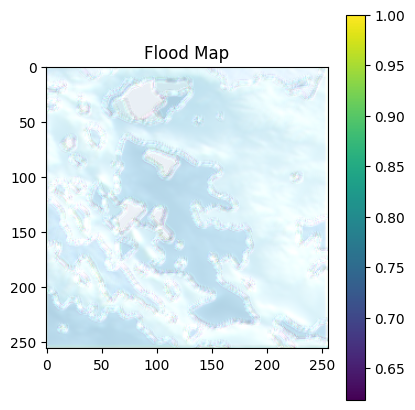

In [ ]:
# Displaying the flood map
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(flood_map)
plt.title('Flood Map')
plt.colorbar()
plt.show()

In [ ]:
floodmap_generator.save("floodmap_generator.keras")  # Saves the model in HDF5 format
print("Model saved successfully.")

Model saved successfully.
